In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def prepData(csv):
    
    df_f = pd.DataFrame()
    for x in csv:
        df = pd.read_csv(x)
        df =  (df[df['AreaName'].isin(['France'])]
                    .set_index('Year')['Value'])
        df_f = pd.concat([df_f, df], axis = 1)
    
    df_f.columns = ["price", 'supply']
    df_f = df_f.dropna()
    
    return df_f

In [3]:
#test = pd.read_csv('146908e8-7a8a-40ea-b670-b39daab67a15.csv')
#(test[test['AreaName'].isin(['France'])]
#                    .set_index('Year')['Value'])

In [4]:
csv = ['https://raw.githubusercontent.com/thomaspernet/PythonFinanceClass/master/QuantitativeFinance/Datasets/146908e8-7a8a-40ea-b670-b39daab67a15.csv',
       'https://raw.githubusercontent.com/thomaspernet/PythonFinanceClass/master/QuantitativeFinance/Datasets/b24e9b0e-4b97-4acc-90f8-599cc178d434.csv']
df = prepData(csv = csv)

In [5]:
df.head()

,price,supply
1991.0,197.27,34344608.0
1992.0,202.50,32545880.0
1993.0,148.33,29209000.0
1994.0,149.67,30500000.0
1995.0,169.49,30880000.0


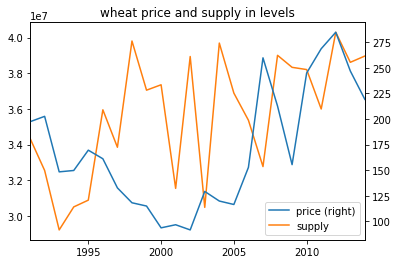

In [6]:
axw = df.loc[:,['price','supply']].plot(secondary_y = 'price',
                                        title='wheat price and supply in levels')
figw = axw.get_figure()

## Returns, ADF test

1. Compute the first difference for the price and supply of wheat in France
2. Perform Augmented Dickey-Fuller tests on both level and first difference5
. Note that from a
plot, it is not clear that the level have a unit root, especially the supply seems to be erratic6
. If
time allow, you can check the ADF test with or without trend

In [7]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [8]:
adf_test(y = df['price'].shift(1).dropna())

Results of Augmented Dickey-Fuller test:
test statistic          -3.601728
p-value                  0.005728
# of lags                9.000000
# of observations       13.000000
Critical Value (1%)     -4.068854
Critical Value (5%)     -3.127149
Critical Value (10%)    -2.701730
dtype: float64


In [9]:
adf_test(y = df['supply'].shift(1).dropna())

Results of Augmented Dickey-Fuller test:
test statistic          -3.606378
p-value                  0.005640
# of lags                0.000000
# of observations       22.000000
Critical Value (1%)     -3.769733
Critical Value (5%)     -3.005426
Critical Value (10%)    -2.642501
dtype: float64


## 4 VAR

1. Select the order of a VAR with the two first difference
2. Fit the VAR with the selected order
3. Plot impulse response functions

The VAR class assumes that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.

In [10]:
df_diff = df.pct_change(1).dropna()
df_diff.head()

,price,supply
1992.0,0.026512,-0.052373
1993.0,-0.267506,-0.102528
1994.0,0.009034,0.044199
1995.0,0.132425,0.012459
1996.0,-0.049501,0.164148


In [11]:
from statsmodels.tsa.api import VAR

In [12]:
varmodel = VAR(df_diff)


/Users/thomas/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
print(varmodel.select_order(maxlags = 5,
                            trend = 'c')
     )
### 1

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC -> 1>


In [14]:
results = varmodel.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Sep, 2019
Time:                     13:01:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.79327
Nobs:                     22.0000    HQIC:                  -7.02073
Log likelihood:           21.5658    FPE:                0.000835562
AIC:                     -7.09083    Det(Omega_mle):     0.000647059
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.031097         0.059025            0.527           0.598
L1.price         -0.015547         0.242581           -0.064           0.949
L1.supply        -0.028155         0.471120           -0.060           0.952

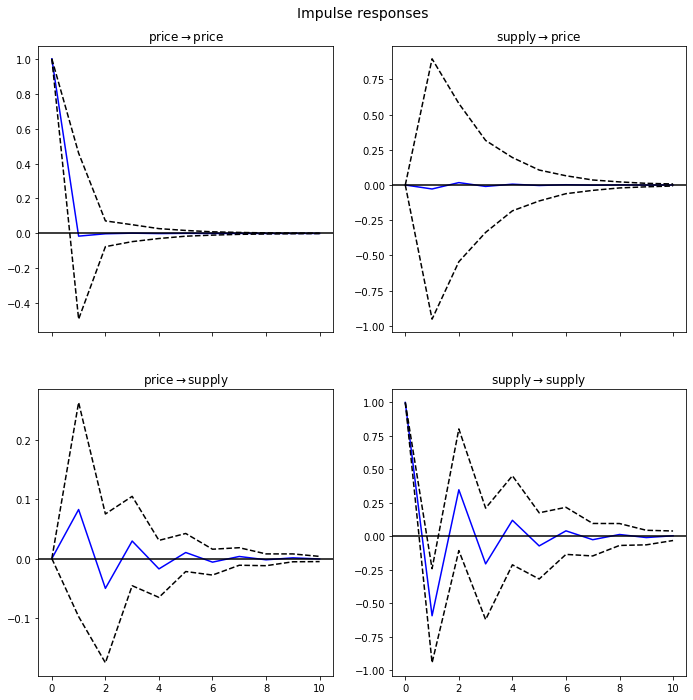

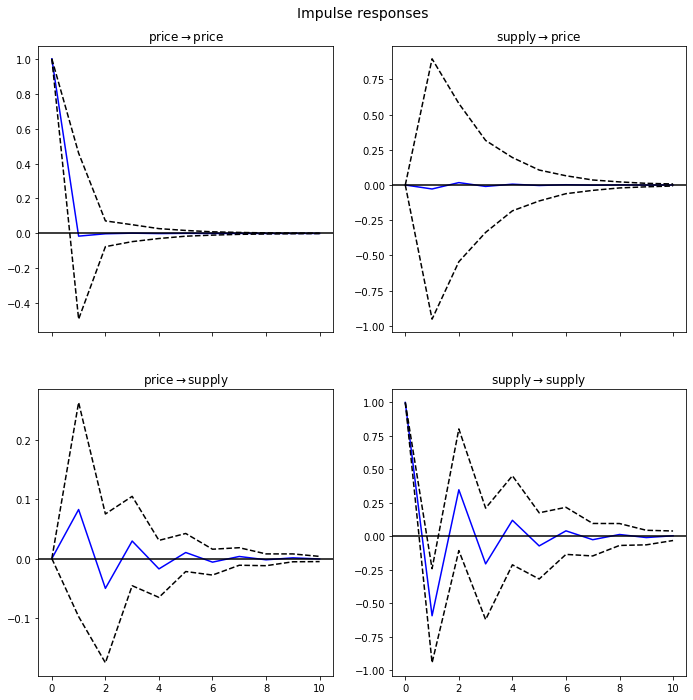

In [15]:
results.irf().plot()

## Correlation

1. Add the lagged variables of both the price and the supply
2. Compute the correlations between the variables: price, supply, lagged price and lagged supply

In [16]:
df['priceLag'] = df['price'].shift(1)
df['supplyLag'] = df['supply'].shift(1)

In [17]:
df.corr()

,price,supply,priceLag,supplyLag
price,1.000000,0.155607,0.776228,0.179369
supply,0.155607,1.000000,0.298592,0.223754
priceLag,0.776228,0.298592,1.000000,0.124757
supplyLag,0.179369,0.223754,0.124757,1.000000
